Peter Meleney  
01/14/16   
v0.04  
  
<h1 align="center">  Predicting Output from Wind Farms in the California Independent System Operator (CAISO) Grid </h1>

## Abstract

Electrical generation at wind farms are greatly influenced by local weather conditions. Since weather is chaotic, and thus unpredictable over long time scales, consistent and accurate short-term prediction is essential to maintaining grid reliability. Without accurate prediction of generation at renewable stations, electrical utilities must either maintain higher operating margins by running more thermal resources (e.g. coal, nuclear, and natural gas) thus negating the environmental benefit of installing renewable generators, or sacrifice grid reliability and risk increased occurrences of brownouts or blackouts.  

This study focuses on the **Ca**lifornia **I**ndependent **S**ystem **O**perator (CAISO) grid because that organization has a policy of open data, meaning a more or less complete record of how many megawatts were produced by wind farms each hour since 4/20/2011 is available online.  The objective of this study is to combine that record with NOAA weather observations to make a hour-ahead wind farm output prediction as accurately as possible.  Minimizing the "maximum observed error" is essential, because the system must maintain additional capacity to handle outliers in order to ensure relieability.  In other words, I would much prefer a constant relative error of 1% to having a mean relative error of 0.1%, while observing multiple outliers of 10% or more.

##1.0 Introduction

The **Ca**lifornia **I**ndependent **S**ystem **O**perator (CAISO) is the largest electrical grid manager in the state of California.  The CAISO has a policy of open data, and reports the hourly output of power stations connected to its grid, aggregated by kind, e.g. the CAISO reports how much electricity was generated by wind farms between 10am and 11am on 05/01/2013. A repository of nearly continuious data since 4/20/2010 is available at http://www.caiso.com/green/renewableswatch.html.  
  
For this study used all available CAISO data between 4/20/2010 and 5/31/2015.  In order to include useful weather data, I  located 65 of the 81 "participating" wind farms contributing to the CAISO grid.  I was unable to find a reliable latitude and longitude location for the final 15 wind farms, all of which have relatively small maximum output (<= 15MW).  Taken together the located wind farms represent nearly 98% of the total current wind capacity of the CAISO, the remaining unlocated farms therefore represent only a little more than 2% of the total capacity.  I lumped the wind farms into 6 groups based on their location (see file CAISOWindEnergyMap.pdf, or slide 9 of the presentation for a map), found the nearest NOAA weather stations to each of those 6 groups with continuious hourly data since 4/20/2010, and downloaded the relivant weather data.  The names and locations of the NOAA weather stations and CAISO wind farms are reported in the dataframes below, WindFarmLocations, and NOAA_StationLocations respecively.

##2.0 Data Sources

### 2.1 Identifying and Locating Wind Farms Connected to the CAISO Grid

As a first step towards including weather data in the analysis of output from wind farms I located as many wind facilities connected to the CAISO grid as possible.  A list of all power plants connected to the CAISO grid is available for download at [this](http://www.caiso.com/Documents/MasterControlAreaGeneratingCapabilityList.xls) web address, I downloaded this resource on 06/05/15.  An updated copy (downloaded on 01/12/16) is available in the "rawData" folder in this project's directory: *MasterControlAreaGeneratingCapabilityList.xls*.  

From this dataset, I used the "Name Plate Capacity" as my estimate of wind farm capacity.  "Nameplate Capacity" is very similar to, but occasionally higher than the other listed capacity, the "Net Dependable Capacity." I chose the former because it is a higher estimate of wind farm capacity, and so was less likely to lead to instances where the system was outputting more than the listed capacity, i.e. % output > 1.0 in figures ***ADD APPLICABLE FIGURE NUMBERS***. 

I sorted this database by the column "ISO Classification" and took all stations labeled "WIND" in that column to be wind farms.  I treated "Non-Participating Units" as non-entities, as each appeared to be a subsidiary part of some "Participating Unit" (see "Classification" column).  Most wind farms were located manually, using the wind farm tool provided by the USGS [here](http://eerscmap.usgs.gov/windfarm/).  All data contained in this web tool is also available in the rawData directory titled *USGS_WindTurbine_201307_csv.csv*.  However, since this database was released in July 2013, it does not contain the most recently constructed wind farms, which I located through google searches. ***THIS SHOULD BE UPDATED WITH A MORE PRECISE EXPLANATION***.  Using these methods I was able to locate 65 of the 81 "Participating" wind units, representing a little under 98% of the systems current capacity.

A rough map of all wind farm locations included in this study is available in the project directory, titled *CAISOWindEnergyMap.pdf*.  The name, latitude-longitude location, and capacity in MW is contained in the pd.DataFrame WindFarmLocations in the code below.

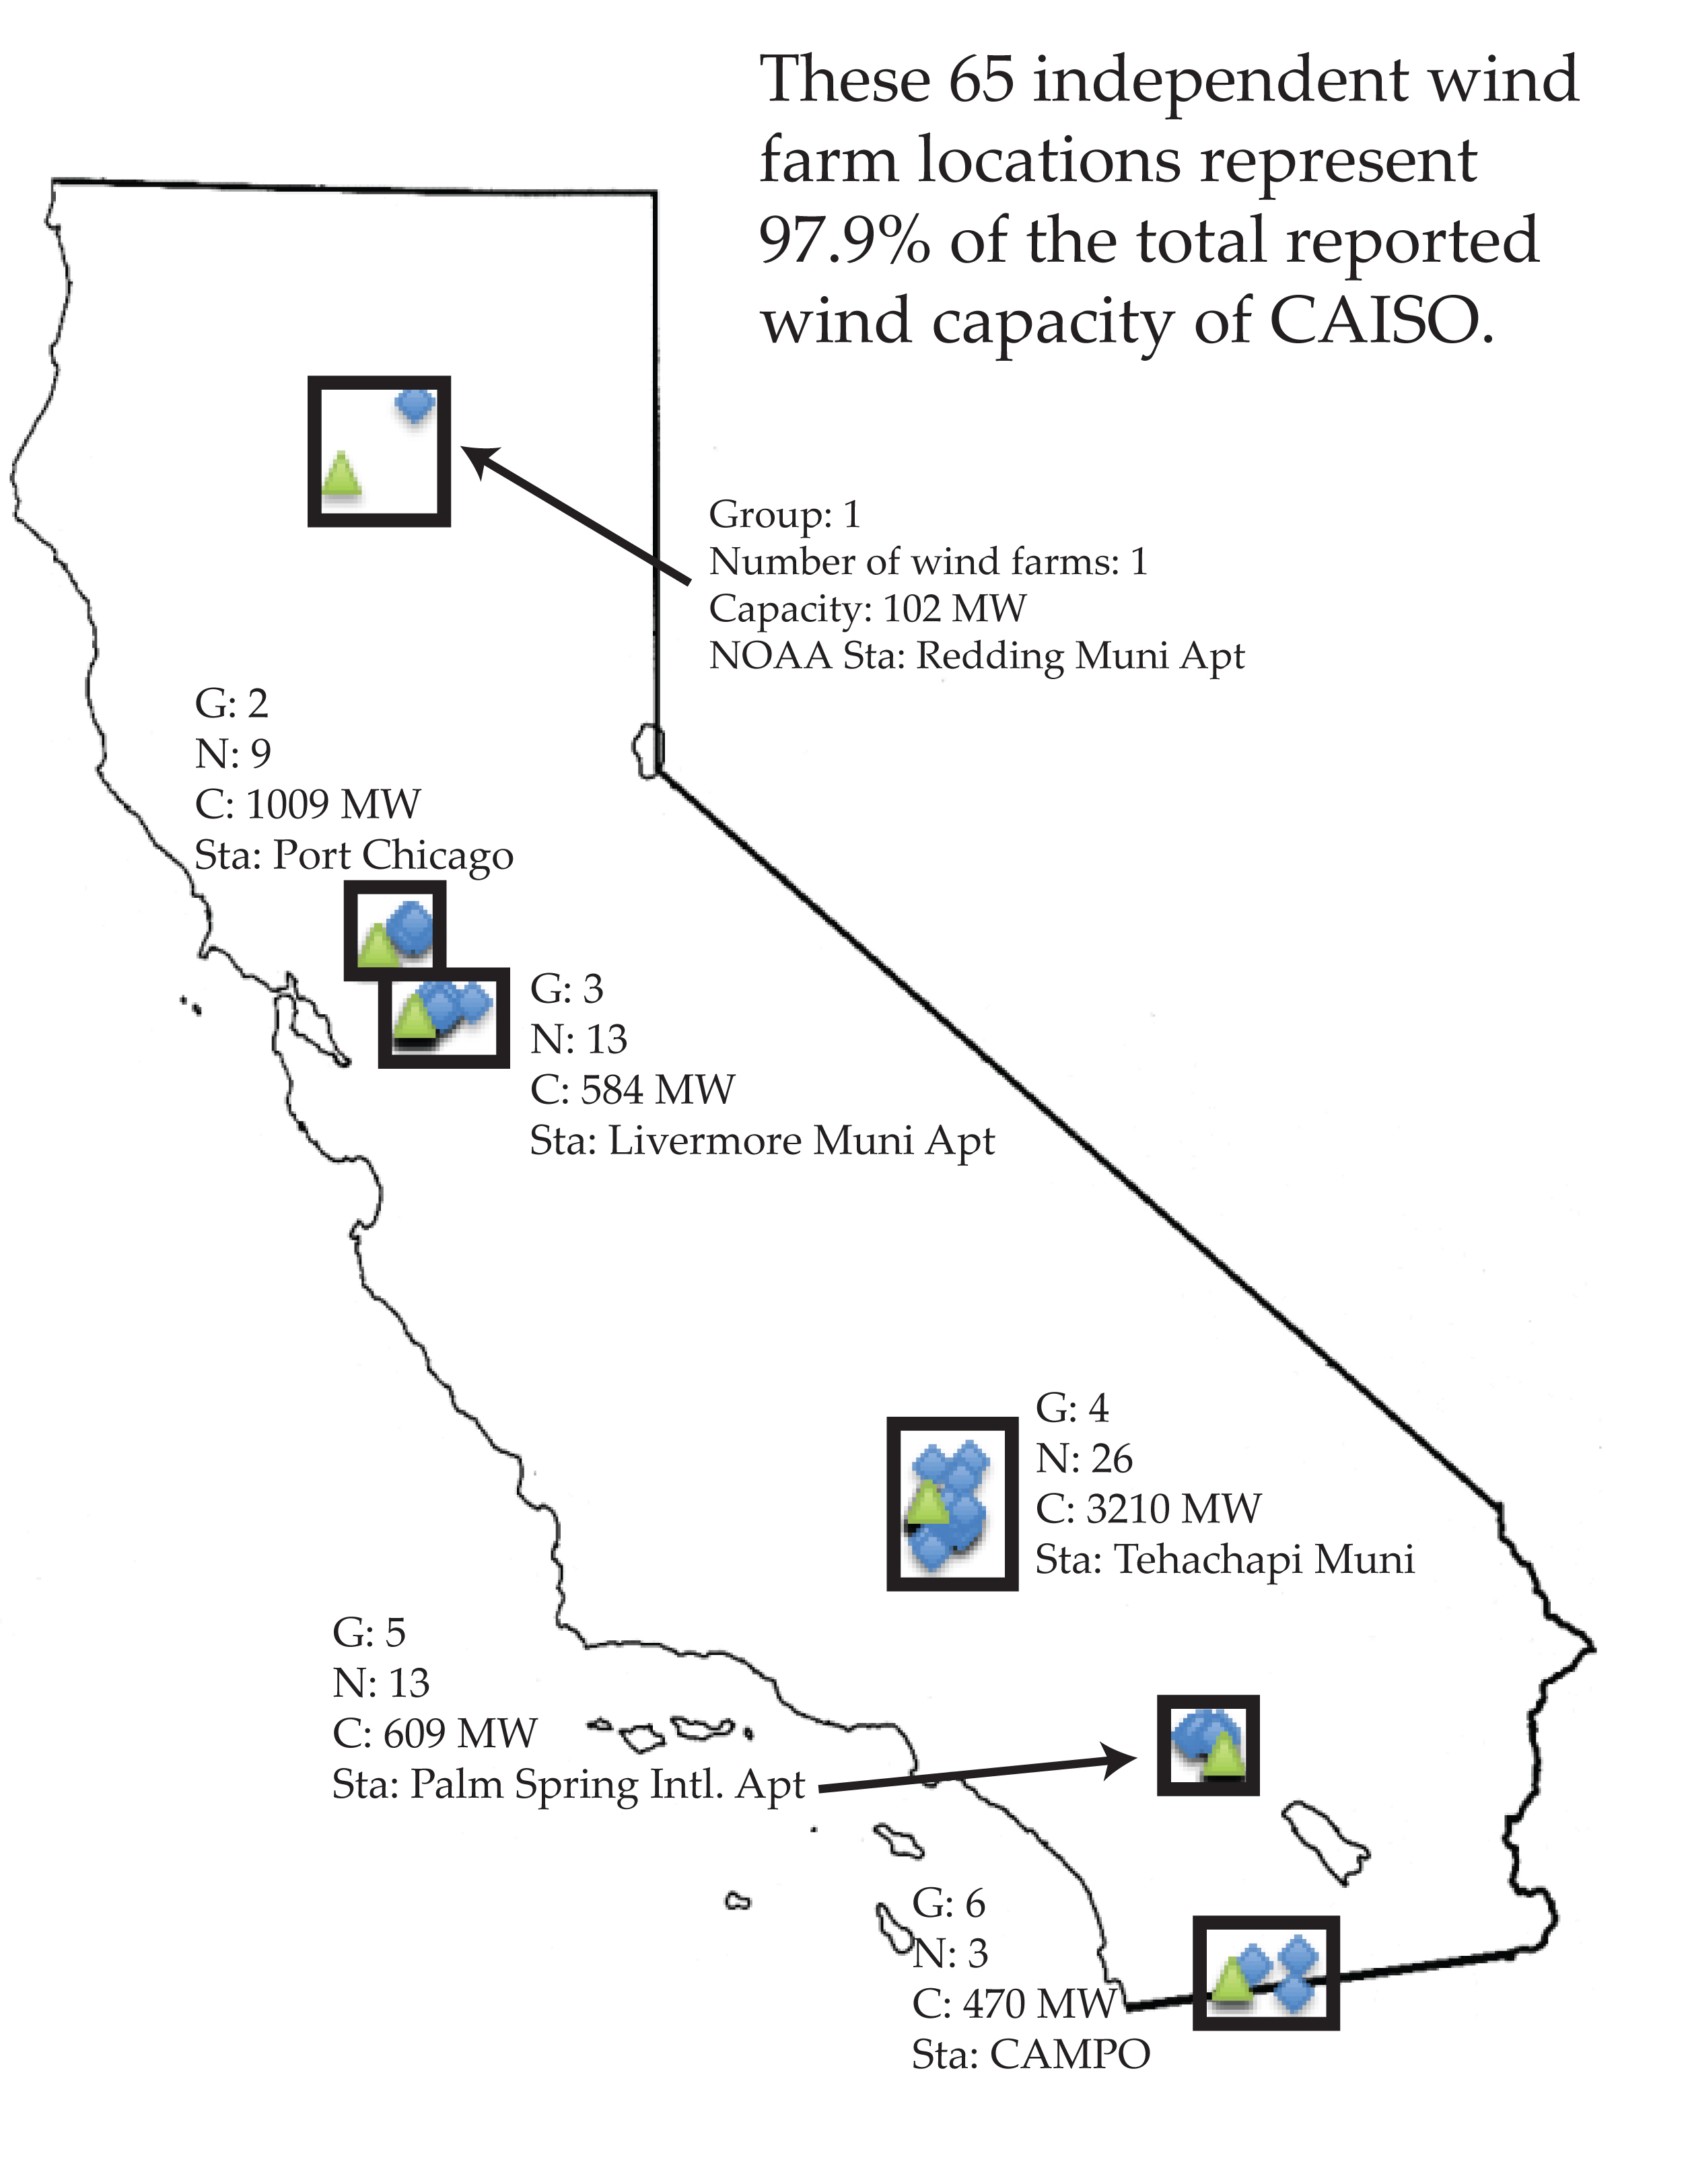

In [199]:
Image(filename='CAISOWindEnergyMap.jpg', width = 400)

In [200]:
WindFarmLocations.head()

,Latitude,Longitude,Capacity (MW)
Name,,,
Ocotillo Wind Energy Facility,32.75,-116.04,265.00
VINCENT AREA LUMPED UNITS,35.31,-118.43,238.90
ANTELOPE VALLEY AREA LUMPED UNITS,35.07,-118.27,211.00
DEVERS AREA LUMPED UNITS,33.92,-116.73,189.99
Manzana Wind,34.93,-118.46,189.00


###2.2 CAISO System Output

CAISO reports how much electricity was generated by each fuel source each hour online on its [renewables watch](http://www.caiso.com/green/renewableswatch.html) website. I downloaded all available data (between 04/20/2010 and 5/31/2015) "Daily Renewables output data for MM/DD/YYYY." The data were plain text files in tab-separated format.  The raw data used for this analysis are available in the project's directory under *data/rawData/CAISO_renewablesWatch*.  I took the column labeled WIND TOTAL as the total electricity generated at all wind stations connected to the CAISO in MW for the indicated hour (See Figure 1).  Notice the dominant upward trend with time.  This is the result of CAISO rapidly incorporating new sources of wind power.

In [201]:
#Figure 1: CAISO Raw Generation at Wind Farms in MW
lo = 0
hi = Data.P_Cap.shape[0]

plt.figure(figsize=(10,6))
plt.title('Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[lo:hi], Data.WindTotal[lo:hi], 'b', linewidth = 0.15)

plt.show()

AttributeError: 'DataFrame' object has no attribute 'P_Cap'

###2.3 CAISO System Capacity and Normalization of Output Target Variable

The CAISO is expanding wind capacity rapidly in order to comply with California Statute [SBX 1-2](http://www.leginfo.ca.gov/pub/11-12/bill/sen/sb_0001-0050/sbx1_2_bill_20110412_chaptered.html), which requires 25% of all retail electricity be generated by renewable sources by the end of 2016, and 33% by the end of 2020.  This results in the raw system output having a strong upward trend over time.  If the model were to attempt to model the raw output directly, it would be like trying to hit a moving target and effectively add systemic error to the model output. 

This problem is addressed by normalizing the target variable to the system capacity.  Effectively the model predicts the ratio of the total system capacity that will be produced in the next hour, instead of predicting the output directly.  This new target largely removes the large-scale upward trend with time (See Figures 2 and 3).

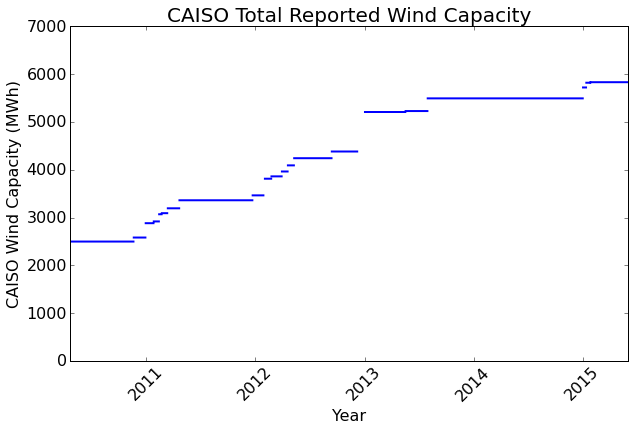

In [202]:
#Figure 2: CAISO Wind Capacity 4/20/2010-5/31/2015

#Axis Ranges
lo = 0
hi = (Data.shape[0])

#Fig Size
plt.figure(figsize=(10,6))

#Title/Axis Label parameters
plt.title('CAISO Total Reported Wind Capacity',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CAISO Wind Capacity (MWh)', fontsize=16)

#Plot Tick Parameters
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation='45')

#Vertical Axis Limits
plt.ylim([0,7000])

#Data Source and Show
plt.plot(Data.index[lo:hi], Data.CAISO_WindCapacity[lo:hi], 'b', linewidth = 2)
plt.show()

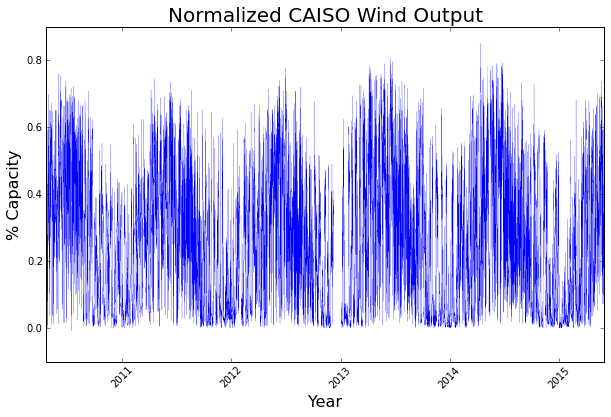

In [203]:
#Figure 3: Normalized CAISO Generation at Wind Farms.
lo = 0
hi = Data.PercentCapacity.shape[0]

plt.figure(figsize=(10,6))
plt.title('Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[lo:hi], Data.PercentCapacity[lo:hi], 'b', linewidth = 0.15)

plt.show()

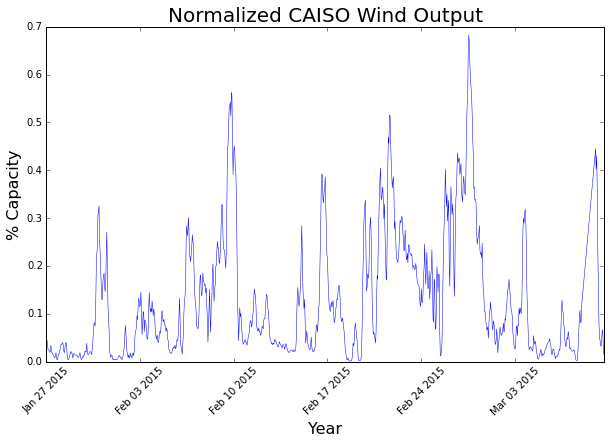

In [204]:
#Figure 3: Normalized CAISO Generation at Wind Farms.
lo = 0
hi = Data.PercentCapacity.shape[0]

plt.figure(figsize=(10,6))
plt.title('Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[hi-3000:hi-2000], Data.PercentCapacity[hi-3000:hi-2000], 'b', linewidth = 0.5)

plt.show()

### 2.4 NOAA Weather Data

In order to incorporate weather data into the model, I separate the 65 wind farms I was able to locate into 6 groups based on their location (See Figure ***ADD FIGURE REFERENCES***).  I then located the nearest NOAA weather station with continuious data from 04/20/2010 through 05/31/2015.  hourly observations of weather conditions are made available throught the NOAA website.  I downloaded hourly observations from the 6 indicated stations in HTML format from the [Quality Controlled Local Climatological Data - California](http://www.ncdc.noaa.gov/qclcd/QCLCD) website.  These data are available in this project's directory under *data/rawData/NOAA_rawWeatherStationData*.

In [205]:
NOAA_StationLocations

,AWS ID,Latitude,Longitude
NOAA Station,,,
CAMPO,747186,32.623,-116.473
Livermore Muni Airport,724927,37.693,-121.814
Palm Springs Intl Airport,722868,33.822,-116.504
Port Chicago,994034,38.057,-122.038
Redding Muni Airport,725920,40.518,-122.299
Tehachapi Muni Airport,749171,35.135,-118.439


##3.0 Data Processing

# CODE

In [206]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pylab
import glob
import time
import Pysolar #version 0.6 is compatible with Python 2.x
import datetime

from __future__ import division
from IPython.display import Image
from patsy import dmatrices, dmatrix

from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import PredefinedSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

%matplotlib inline

### Table 1

In [207]:
WindFarmLocations = pd.read_csv('data/processedData/CAISO_WindFarmLocations.csv', index_col = 0)

In [208]:
WindFarmLocations.head()

,Latitude,Longitude,Capacity (MW)
Name,,,
Ocotillo Wind Energy Facility,32.75,-116.04,265.00
VINCENT AREA LUMPED UNITS,35.31,-118.43,238.90
ANTELOPE VALLEY AREA LUMPED UNITS,35.07,-118.27,211.00
DEVERS AREA LUMPED UNITS,33.92,-116.73,189.99
Manzana Wind,34.93,-118.46,189.00


### Table 2

In [10]:
NOAA_StationLocations = pd.read_csv('data/processedData/NOAA_StationLocations.csv', index_col = 0)

In [11]:
NOAA_StationLocations

,AWS ID,Latitude,Longitude
NOAA Station,,,
CAMPO,747186,32.623,-116.473
Livermore Muni Airport,724927,37.693,-121.814
Palm Springs Intl Airport,722868,33.822,-116.504
Port Chicago,994034,38.057,-122.038
Redding Muni Airport,725920,40.518,-122.299
Tehachapi Muni Airport,749171,35.135,-118.439


###Figure 1

In [171]:
CAISO_Onboarding.iloc[45::]

,Capacity
2013-01-01,5074.38
2013-01-01,5206.38
2013-05-17,5206.38
2013-05-17,5226.33
2013-07-30,5226.33
2013-07-30,5491.33
2015-01-01,5491.33
2015-01-01,5629.33
2015-01-01,5629.33
2015-01-01,5719.33


In [174]:
# I will fill in the capacity of the CAISO wind system will be done by hand.  This dataframe is NaN by default.

windCap_CAISO = pd.DataFrame(45072*[np.NaN], 
                             index = pd.date_range(start = pd.to_datetime('2010-04-10 00:00:00'), 
                                                   end = pd.to_datetime('2015-05-31 23:00:00'), freq = 'H'), 
                             columns = ['CAISO_WindCapacity'])

In [175]:
# I calculated the CAISO system capacity by hand. The raw data used in this
# calculation is available in MasterControlAreaGeneratingCapabilityList.xls.
# Days in which new wind farms come oneline are excluded from this dataframe, and
# will be excluded from the model, because I don't know what time of day they were activated.

windCap_CAISO[pd.to_datetime('2010-04-10'):pd.to_datetime('2010-11-18 23:00:00')] = 2497.58
windCap_CAISO[pd.to_datetime('2010-11-20'):pd.to_datetime('2010-12-28 23:00:00')] = 2581.58
windCap_CAISO[pd.to_datetime('2010-12-30'):pd.to_datetime('2011-01-24 23:00:00')] = 2881.58
windCap_CAISO[pd.to_datetime('2011-01-26'):pd.to_datetime('2011-02-11 23:00:00')] = 2918.38
windCap_CAISO[pd.to_datetime('2011-02-13'):pd.to_datetime('2011-02-20 23:00:00')] = 3068.38
windCap_CAISO[pd.to_datetime('2011-02-22'):pd.to_datetime('2011-03-11 23:00:00')] = 3090.88
windCap_CAISO[pd.to_datetime('2011-03-13'):pd.to_datetime('2011-04-20 23:00:00')] = 3192.88
windCap_CAISO[pd.to_datetime('2011-04-22'):pd.to_datetime('2011-12-21 23:00:00')] = 3360.88
windCap_CAISO[pd.to_datetime('2011-12-23'):pd.to_datetime('2012-01-27 23:00:00')] = 3463.38
windCap_CAISO[pd.to_datetime('2012-02-02'):pd.to_datetime('2012-02-22 23:00:00')] = 3811.58
windCap_CAISO[pd.to_datetime('2012-02-24'):pd.to_datetime('2012-03-28 23:00:00')] = 3860.58
windCap_CAISO[pd.to_datetime('2012-03-30'):pd.to_datetime('2012-04-17 23:00:00')] = 3962.58
windCap_CAISO[pd.to_datetime('2012-04-19'):pd.to_datetime('2012-05-08 23:00:00')] = 4090.38
windCap_CAISO[pd.to_datetime('2012-05-10'):pd.to_datetime('2012-09-11 23:00:00')] = 4240.38
windCap_CAISO[pd.to_datetime('2012-09-13'):pd.to_datetime('2012-12-06 23:00:00')] = 4380.38
windCap_CAISO[pd.to_datetime('2013-01-02'):pd.to_datetime('2013-05-16 23:00:00')] = 5206.38
windCap_CAISO[pd.to_datetime('2013-05-18'):pd.to_datetime('2013-07-29 23:00:00')] = 5226.33
windCap_CAISO[pd.to_datetime('2013-07-31'):pd.to_datetime('2014-12-31 23:00:00')] = 5491.33
windCap_CAISO[pd.to_datetime('2015-01-02'):pd.to_datetime('2015-01-11 23:00:00')] = 5719.33
windCap_CAISO[pd.to_datetime('2015-01-13'):pd.to_datetime('2015-01-25 23:00:00')] = 5818.33
windCap_CAISO[pd.to_datetime('2015-01-27'):pd.to_datetime('2015-05-31 23:00:00')] = 5829.53

In [209]:
Data = raw_CAISO
Data['CAISO_WindCapacity'] = windCap_CAISO.CAISO_WindCapacity
Data['PercentCapacity'] = Data.WindOutput_MW / Data.CAISO_WindCapacity

In [210]:
Data.sample(10)

,WindOutput_MW,CAISO_WindCapacity,PercentCapacity
2011-06-29 14:00:00,1393,3360.88,0.414475
2010-07-21 19:00:00,1555,2497.58,0.622603
2011-08-08 08:00:00,943,3360.88,0.280581
2011-01-30 13:00:00,944,2918.38,0.323467
2014-03-19 10:00:00,313,5491.33,0.056999
2012-12-10 02:00:00,162,NaN,NaN
2012-05-18 10:00:00,1877,4240.38,0.442649
2011-10-14 15:00:00,24,3360.88,0.007141
2014-01-16 08:00:00,304,5491.33,0.055360
2014-03-14 22:00:00,3013,5491.33,0.548683


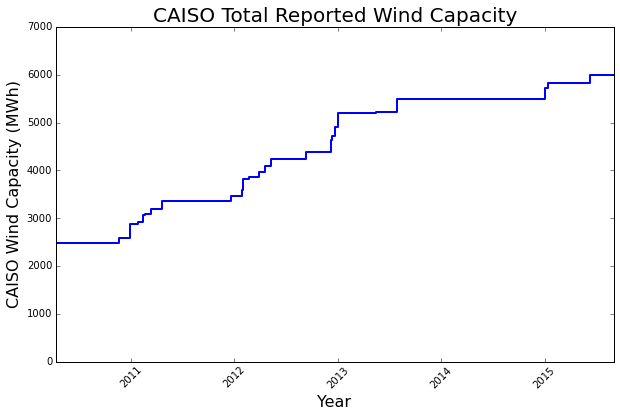

In [14]:
a

## 2.0 Data Import

In [15]:
#This is a list of all .txt files in the TXT files directory
CAISO_fileList = glob.glob('data/rawData/CAISO_renewablesWatch/*.txt')

In [16]:
#Count of the length of file_list, and the expected length of the final DataFrame

print 'The length of the file list is : ', len(CAISO_fileList)
print 'The expected length of the DataFrame is: ' + str(24*len(CAISO_fileList))

The length of the file list is :  1865
The expected length of the DataFrame is: 44760


In [91]:
# This is a list of file that the data import loop skips.  
# I'm not sure how CAISO dealt with daylight savings time.  Daylight savings days are skipped

CAISO_skipList = ['data/rawData/CAISO_renewablesWatch/20100806_DailyRenewablesWatch.txt', #Data Corrupt [No data for calculation]
                  'data/rawData/CAISO_renewablesWatch/20101029_DailyRenewablesWatch.txt', #Contains unusable data
                  'data/rawData/CAISO_renewablesWatch/20101107_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20110313_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20110630_DailyRenewablesWatch.txt', #Data Corrupt [Connection to the server lost]
                  'data/rawData/CAISO_renewablesWatch/20110716_DailyRenewablesWatch.txt', #Data corrupt #NAME?
                  'data/rawData/CAISO_renewablesWatch/20111106_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20120228_DailyRenewablesWatch.txt', #dtype float, normally int
                  'data/rawData/CAISO_renewablesWatch/20120311_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20130310_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20131103_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20140309_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20141102_DailyRenewablesWatch.txt', #daylight savings
                  'data/rawData/CAISO_renewablesWatch/20150308_DailyRenewablesWatch.txt'] #daylight savings


In [98]:
raw_CAISO = pd.DataFrame([], columns = ['WindTotal'])

for f in CAISO_fileList:
    if f in CAISO_skipList:
        continue
        
    raw_CAISOHolder = pd.read_csv(f, sep = None, engine = 'python', header = True) #import each file
    
    
    #pd.read_csv sometimes improperly assigns column names.  How this occurs changes based on the number
    #of columns in the .txt file.  I handle the issue by directly naming the columns here.
    if raw_CAISOHolder.shape[1] == 14:
        raw_CAISOHolder.columns = ['BLANK', 'Hour','BLANK','Geothermal','BLANK', 'Biomass','BLANK', 'Biogas', 
                'BLANK','Small Hydro','BLANK', 'WindTotal', 'BLANK','SolarPV' ]
    elif raw_CAISOHolder.shape[1] == 16:
        raw_CAISOHolder.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','SolarThermal' ]
    elif raw_CAISOHolder.shape[1] == 17:
        raw_CAISOHolder.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','NONE','SolarThermal']
    elif raw_CAISOHolder.shape[1] == 18:
        raw_CAISOHolder.columns = ['NONE', 'Hour','NONE','Geothermal','NONE', 'Biomass','NONE', 'Biogas', 
                'NONE','Small Hydro','NONE', 'WindTotal', 'NONE','SolarPV','NONE','SolarThermal','NONE','NONE' ]
    
    
    raw_CAISOHolder = raw_CAISOHolder.iloc[0:24,:] #Select rows that contain Wind data
    raw_CAISOHolder.Hour = raw_CAISOHolder.Hour.astype(int) - 1 #CAISO hours are 1-indexed, change to 0-index to match datetime
    raw_CAISOHolder['INDEX'] = f[35:43] + '_' + raw_CAISOHolder.Hour.astype(str) #Extract date from filename
    raw_CAISOHolder = raw_CAISOHolder.loc[:,('INDEX', 'WindTotal')] #Remove irrelevant columns
    raw_CAISOHolder.index = pd.to_datetime(raw_CAISOHolder.INDEX[0:24], format = "%Y%m%d_%H") #Reindex to datetime dtype
    raw_CAISOHolder = raw_CAISOHolder.drop(['INDEX'], axis = 1) #Drop INDEX column, no longer needed
    
    raw_CAISO = pd.concat([raw_CAISO, raw_CAISOHolder], axis = 0) #build rawData from each file iteratively

raw_CAISO.columns = ['WindOutput_MW']
raw_CAISO.WindOutput_MW = raw_CAISO.WindOutput_MW.astype(int)

In [100]:
#Several hours indicate that power was consumed by wind farms.  I leave thses data in the model, they don't
#appear to affect the outcome much, but it is good to be aware that the power flow is not always positive
#in the training set.

raw_CAISO.loc[raw_CAISO.WindOutput_MW < 0]

,WindOutput_MW
2010-04-25 13:00:00,-2
2010-07-15 10:00:00,-15
2010-07-15 11:00:00,-21
2010-07-15 12:00:00,-12
2010-07-15 13:00:00,-7
2010-12-02 05:00:00,-1
2010-12-02 07:00:00,-1
2010-12-02 08:00:00,-2


##NOAA Data Import

In [211]:
#Lists all the files in the data folder

file_list_CAMPO = glob.glob('data/rawData/NOAA_rawWeatherStationData/CAMPO/*.html')
file_list_Livermore = glob.glob('data/rawData/NOAA_rawWeatherStationData/LivermoreMuniApt/*.html')
file_list_PSIA = glob.glob('data/rawData/NOAA_rawWeatherStationData/PalmSpringsIntlApt/*.html')
file_list_PortChicago = glob.glob('data/rawData/NOAA_rawWeatherStationData/PortChicago/*.html')
file_list_Redding = glob.glob('data/rawData/NOAA_rawWeatherStationData/ReddingMuniApt/*.html')
file_list_Tehachapi = glob.glob('data/rawData/NOAA_rawWeatherStationData/TehachapiMunicipal/*.html')

In [212]:
#All file lists should have 62 elements.  One for each month 4/2010 - 5/2015 inclusive.

[len(file_list_CAMPO),
len(file_list_Livermore),
len(file_list_PSIA),
len(file_list_PortChicago),
len(file_list_Redding),
len(file_list_Tehachapi)]

[62, 62, 62, 62, 62, 62]

In [291]:
#Programatically load NOAA station observation data into pd.DataFrame with appropriately
#named columns.  These DataFrames will be concatinated later, so column names should be
#unique.

#file_list is a list of files to be loaded, NOAAStation is a str to be concatinated 
#with the column titles.  Returns a pd.DataFrame.

def loadNOAAData(file_list, NOAAStation):
    
    DataHolder = pd.DataFrame([])
    
    #Load HTML file into DataHolder
    for f in file_list:
        data_raw = pd.read_html(f)
        data_raw = pd.DataFrame(data_raw[1])
        data_raw.columns = data_raw.iloc[0,:]
        data_raw = data_raw.iloc[2:,:]
        data_raw = data_raw[['YR--MODAHRMN','DIR',
                        'SPD','GUS','TEMP','DEWP','SLP','STP']]
        DataHolder = pd.concat([DataHolder, data_raw], axis = 0)
    
    #Deal with NAN and non-sensical data entries
    DataHolder.SPD = DataHolder.SPD.replace('***',0) #numerical
    DataHolder.GUS = DataHolder.GUS.replace('***',0) #numerical
    DataHolder.DIR = DataHolder.DIR.replace(['***','990'],['No_Wind','DIR_Not_Reported']) #class
    DataHolder.STP = DataHolder.STP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.SLP = DataHolder.SLP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.TEMP = DataHolder.TEMP.replace('****', np.nan) #numerical
    DataHolder.DEWP = DataHolder.DEWP.replace('****', np.nan) #numerical
    
    #Change dtypes to those appropriate for modeling
    DataHolder['YR--MODAHRMN'] = pd.to_datetime(DataHolder['YR--MODAHRMN'], format = '%Y%m%d%H%M')
    DataHolder.SPD = DataHolder.SPD.astype(int)
    DataHolder.GUS = DataHolder.GUS.astype(int)
    DataHolder.DIR = DataHolder.DIR.astype(str)
    DataHolder.STP = DataHolder.STP.astype(float)
    DataHolder.SLP = DataHolder.SLP.astype(float)
    DataHolder.TEMP = DataHolder.TEMP.astype(float)
    DataHolder.DEWP = DataHolder.DEWP.astype(float)
    
    #Rename columns to unique headdings
    DataHolder.columns = [NOAAStation + '_INDEX',NOAAStation + '_Wind_Dir',
                          NOAAStation + '_Wind_Spd',NOAAStation + '_Gust_Spd',
                          NOAAStation + '_Temp',NOAAStation + '_Dew_Pt',
                          NOAAStation + '_SLP',NOAAStation + '_StaP']
    
    DataHolder = DataHolder.dropna() #Drop all rows with any NA values
    
    #Round to the nearest hour, and then drop all instances for which there is more than one observation
    #DataHolder[NOAAStation + '_INDEX'] = [np.round(x,-2)//100 for x in DataHolder[NOAAStation + '_INDEX']]
    #DataHolder = DataHolder.drop_duplicates(subset = NOAAStation + '_INDEX')
    
    #Reindex the 
    DataHolder.index = DataHolder[NOAAStation + '_INDEX'].astype(int)

    print 'loadNOAAData(' + NOAAStation + ') Completed.'
    return DataHolder

In [292]:
#This function is nearly identical to the one above, but excludes Station Pressue and Dew Point data from the 
#loaded columns because these data were not reported for Port Chicago Station.  

def loadNOAAData_PortChicago(file_list, NOAAStation):
    
    DataHolder = pd.DataFrame([])
    
    #Load HTML file into DataHolder
    for f in file_list:
        data_raw = pd.read_html(f)
        data_raw = pd.DataFrame(data_raw[1])
        data_raw.columns = data_raw.iloc[0,:]
        data_raw = data_raw.iloc[2:,:]
        data_raw = data_raw[['YR--MODAHRMN','DIR',
                        'SPD','GUS','TEMP','SLP']]
        DataHolder = pd.concat([DataHolder, data_raw], axis = 0)
    
    #Deal with NAN and non-sensical data entries
    DataHolder.SPD = DataHolder.SPD.replace('***',0) #numerical
    DataHolder.GUS = DataHolder.GUS.replace('***',0) #numerical
    DataHolder.DIR = DataHolder.DIR.replace(['***','990'],['No_Wind','DIR_Not_Reported']) #class
    DataHolder.SLP = DataHolder.SLP.replace(['****','******'],[np.nan, np.nan]) #numerical
    DataHolder.TEMP = DataHolder.TEMP.replace('****', np.nan) #numerical
    
    DataHolder['YR--MODAHRMN'] = pd.to_datetime(DataHolder['YR--MODAHRMN'], format = '%Y%m%d%H%M')
    DataHolder.SPD = DataHolder.SPD.astype(int)
    DataHolder.GUS = DataHolder.GUS.astype(int)
    DataHolder.DIR = DataHolder.DIR.astype(str)
    DataHolder.SLP = DataHolder.SLP.astype(float)
    DataHolder.TEMP = DataHolder.TEMP.astype(float)
    
    #Rename columns to unique headdings
    DataHolder.columns = [NOAAStation + '_INDEX',NOAAStation + '_Wind_Dir',
                          NOAAStation + '_Wind_Spd',NOAAStation + '_Gust_Spd',
                          NOAAStation + '_Temp',
                          NOAAStation + '_SLP']
    
    DataHolder = DataHolder.dropna() #Drop all rows with any NA values
    
    #Round to the nearest hour, and then drop all instances for which there is more than one observation
    #DataHolder[NOAAStation + '_INDEX'] = [np.round(x,-2)//100 + 1 for x in DataHolder[NOAAStation + '_INDEX']]
    #DataHolder = DataHolder.drop_duplicates(subset = NOAAStation + '_INDEX')
    
    #Reindex the 
    DataHolder.index = DataHolder[NOAAStation + '_INDEX']
    
    print 'loadNOAAData(' + NOAAStation + ') Completed.'
    return DataHolder

In [293]:
#This cell loads all NOAA station data, it takes a while to run. (~3min on my laptop)

Start = time.time()

NOAA_Data_CAMPO = loadNOAAData(file_list_CAMPO, 'CAMPO')
NOAA_Data_Livermore = loadNOAAData(file_list_Livermore, 'Livermore')
NOAA_Data_PSIA = loadNOAAData(file_list_PSIA, 'PSIA')
NOAA_Data_Redding = loadNOAAData(file_list_Redding, 'Redding')
NOAA_Data_Tehachapi = loadNOAAData(file_list_Tehachapi, 'Tehachapi')

#Port Chicago treated seperately because Station Pressure and Dew Point were never reported
NOAA_Data_PortChicago = loadNOAAData_PortChicago(file_list_PortChicago, 'PortChicago')

print ""
print "COMPLETED LOADING ALL DATA"
print "Elapsed time = " + str(int(time.time()-Start)) + " seconds."

loadNOAAData(CAMPO) Completed.
loadNOAAData(Livermore) Completed.
loadNOAAData(PSIA) Completed.
loadNOAAData(Redding) Completed.
loadNOAAData(Tehachapi) Completed.
loadNOAAData(PortChicago) Completed.

COMPLETED LOADING ALL DATA
Elapsed time = 263 seconds.


In [295]:
NOAA_Data_CAMPO.head()

,CAMPO_INDEX,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP
CAMPO_INDEX,,,,,,,,
1270083120000000000,2010-04-01 00:52:00,220,15,0,48,32,1008.7,917.9
1270086720000000000,2010-04-01 01:52:00,240,14,0,46,38,1009.0,918.2
1270090320000000000,2010-04-01 02:52:00,240,11,0,44,38,1009.3,918.5
1270093920000000000,2010-04-01 03:52:00,240,11,0,43,40,1009.9,918.8
1270097520000000000,2010-04-01 04:52:00,230,13,18,43,40,1010.5,919.4


In [296]:
NOAA_Data_PortChicago.head()

,PortChicago_INDEX,PortChicago_Wind_Dir,PortChicago_Wind_Spd,PortChicago_Gust_Spd,PortChicago_Temp,PortChicago_SLP
PortChicago_INDEX,,,,,,
2010-04-01 00:00:00,2010-04-01 00:00:00,260,21,0,52,1009.4
2010-04-01 01:00:00,2010-04-01 01:00:00,220,6,0,51,1009.6
2010-04-01 02:00:00,2010-04-01 02:00:00,250,17,0,49,1009.6
2010-04-01 03:00:00,2010-04-01 03:00:00,220,7,0,47,1010.4
2010-04-01 04:00:00,2010-04-01 04:00:00,240,7,0,47,1011.0


In [261]:
NOAA_Data_CAMPO.CAMPO_INDEX = NOAA_Data_CAMPO.CAMPO_INDEX - 1

In [262]:
NOAA_Data_CAMPO.CAMPO_INDEX = pd.to_datetime(NOAA_Data_CAMPO.CAMPO_INDEX.astype(str), format = '%Y%m%d%H')

ValueError: unconverted data remains: 9

In [282]:
NOAA_Data_CAMPO.loc[2010062120:2010062210]

,CAMPO_INDEX,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP
CAMPO_INDEX,,,,,,,,
2010062120,2010062119,230,10,17,85,39,1012.3,922.9
2010062122,2010062121,220,15,20,86,30,1011.7,922.3
2010062123,2010062122,220,14,20,85,37,1011.8,922.3
2010062124,2010062123,220,16,0,84,39,1011.6,921.9
2010062200,2010062199,230,11,0,82,42,1011.3,921.6
2010062202,2010062201,220,11,0,79,45,1011.5,921.9
2010062203,2010062202,190,6,0,62,47,1012.0,922.3
2010062204,2010062203,No_Wind,0,0,59,47,1011.8,922.6
2010062205,2010062204,040,3,0,52,42,1012.6,923.2


In [277]:
for ind in range(0,NOAA_Data_CAMPO.CAMPO_INDEX.shape[0]):
    print pd.to_datetime(str(NOAA_Data_CAMPO.CAMPO_INDEX.iloc[ind]), format = '%Y%m%d%H')

2010-04-01 00:00:00
2010-04-01 01:00:00
2010-04-01 02:00:00
2010-04-01 03:00:00
2010-04-01 04:00:00
2010-04-01 05:00:00
2010-04-01 06:00:00
2010-04-01 07:00:00
2010-04-01 08:00:00
2010-04-01 09:00:00
2010-04-01 10:00:00
2010-04-01 11:00:00
2010-04-01 12:00:00
2010-04-01 13:00:00
2010-04-01 14:00:00
2010-04-01 15:00:00
2010-04-01 16:00:00
2010-04-01 17:00:00
2010-04-01 18:00:00
2010-04-01 19:00:00
2010-04-01 20:00:00
2010-04-01 21:00:00
2010-04-01 22:00:00
2010-04-01 23:00:00
2010-04-02 00:00:00
2010-04-02 01:00:00
2010-04-02 02:00:00
2010-04-02 03:00:00
2010-04-02 04:00:00
2010-04-02 05:00:00
2010-04-02 06:00:00
2010-04-02 07:00:00
2010-04-02 08:00:00
2010-04-02 09:00:00
2010-04-02 10:00:00
2010-04-02 11:00:00
2010-04-02 12:00:00
2010-04-02 13:00:00
2010-04-02 14:00:00
2010-04-02 15:00:00
2010-04-02 16:00:00
2010-04-02 17:00:00
2010-04-02 18:00:00
2010-04-02 19:00:00
2010-04-02 20:00:00
2010-04-02 21:00:00
2010-04-02 22:00:00
2010-04-02 23:00:00
2010-04-03 00:00:00
2010-04-03 01:00:00


ValueError: unconverted data remains: 9

In [269]:
NOAA_Data_CAMPO.CAMPO_INDEX.iloc[0]

2010040100

In [287]:
np.round(157.22,-2)

200.0

In [18]:
#Reindex the Data df such that missing data is filled with NaN
Data = Data.reindex(pd.date_range('4/20/2010', periods=44831, freq='H')) 

Data.isnull().any().any() #Checks that null data now do exist in the Data df, should be True

True

In [19]:
#2014-07-06 15:00:00 and 16:00:00 should be NaN

index = 36926
Data[index:index+4]

,CAMPO_Wind_Dir,CAMPO_Wind_Spd,CAMPO_Gust_Spd,CAMPO_Temp,CAMPO_Dew_Pt,CAMPO_SLP,CAMPO_StaP,Livermore_Wind_Dir,Livermore_Wind_Spd,Livermore_Gust_Spd,Livermore_Temp,Livermore_Dew_Pt,Livermore_SLP,Livermore_StaP,PSIA_Wind_Dir,PSIA_Wind_Spd,PSIA_Gust_Spd,PSIA_Temp,PSIA_Dew_Pt,PSIA_SLP,PSIA_StaP,PortChicago_Wind_Dir,PortChicago_Wind_Spd,PortChicago_Gust_Spd,PortChicago_Temp,PortChicago_SLP,Redding_Wind_Dir,Redding_Wind_Spd,Redding_Gust_Spd,Redding_Temp,Redding_Dew_Pt,Redding_SLP,Redding_StaP,Tehachapi_Wind_Dir,Tehachapi_Wind_Spd,Tehachapi_Gust_Spd,Tehachapi_Temp,Tehachapi_Dew_Pt,Tehachapi_SLP,Tehachapi_StaP,WindTotal,YEAR,MONTH,DAY,HOUR,Total_Capacity,P_Cap,Max_Sun_Angle
2014-07-06 14:00:00,No_Wind,0,0,73,50,1014.6,925.7,No_Wind,0,0,64,48,1016.4,1002.4,No_Wind,0,0,92,50,1012.9,997.2,260,22,0,57,1016.3,No_Wind,0,0,73,50,1014.6,925.7,No_Wind,0,0,73,50,1014.6,925.7,1572,2014,7,6,15,5491.33,0.286269,77.622842
2014-07-06 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-06 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-06 17:00:00,220,18,0,86,45,1013.8,924.8,270,6,0,83,40,1015.9,1001.8,160,5,0,101,52,1012.5,996.8,280,17,0,62,1016.8,220,18,0,86,45,1013.8,924.8,220,18,0,86,45,1013.8,924.8,3193,2014,7,6,18,5491.33,0.581462,77.622842


####2.1.1 Raw Data Visual Exploration

In [14]:
#Plot of all WindTotal data
lo = 0
hi = Data.WindTotal.shape[0]

plt.figure(figsize=(10,6))
plt.title('Raw CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('Raw Output (MWh)', fontsize=16)

plt.plot(Data.index[lo:hi], Data.WindTotal[lo:hi], 'b', linewidth = 0.15)

plt.show()

NameError: name 'Data' is not defined

***Caption:*** The raw CAISO Wind Output trends upwards over time as CAISO adds capacity.

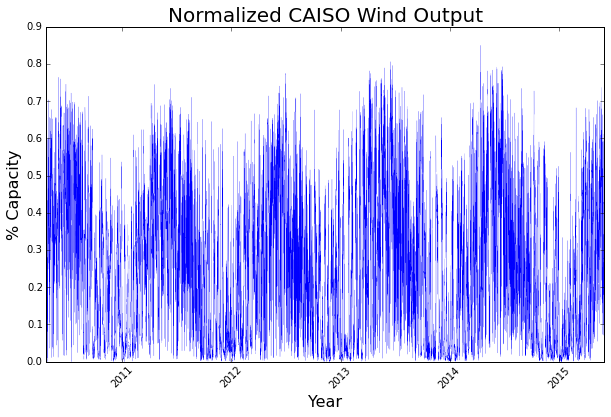

In [21]:
#Plot of all WindTotal data
lo = 0
hi = Data.P_Cap.shape[0]

plt.figure(figsize=(10,6))
plt.title('Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[lo:hi], Data.P_Cap[lo:hi], 'b', linewidth = 0.15)

plt.show()

***Caption:*** The normalized output has daily and yearly cycles, but the overall upward trend is largely removed.

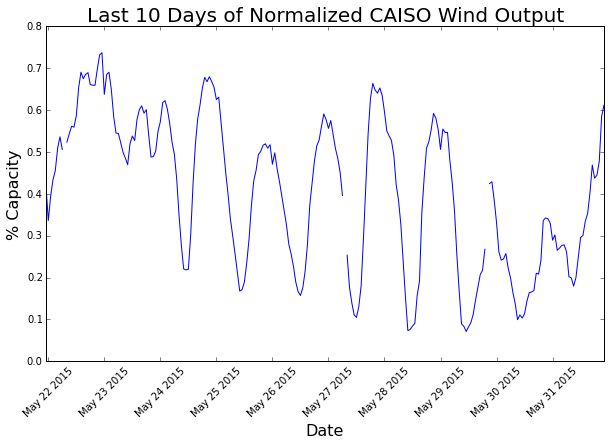

In [22]:
#Plot of all WindTotal data
lo = Data.P_Cap.shape[0]-240
hi = Data.P_Cap.shape[0]

plt.figure(figsize=(10,6))
plt.title('Last 10 Days of Normalized CAISO Wind Output',  fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.xticks(rotation='45')
plt.ylabel('% Capacity', fontsize=16)

plt.plot(Data.index[lo:hi], Data.P_Cap[lo:hi], 'b', linewidth = 1)

***Caption:*** This is a detailed look at the final 10 days of normalized wind generation.  At this scale the daily cycles are easy to recognize.  Gaps in the chart reflect data that are missing either from the CAISO dataset, or from the NOAA record.

###2.2 Feature Engineering

####2.2.1 Trailing Data

In [23]:
#Data becomes a sparce matrix with a continuious index.  Many rows have missing data.  The important change is that
#now data that appears after dropped days has NaN for data before them.  Trailing Data can then be created 

Data_Range = pd.date_range(Data.index[0], periods=8760*6, freq='H') #6 years of hourly indices
DataNaN_Holder = pd.DataFrame([], index = Data_Range)
Data = pd.concat([Data,DataNaN_Holder])

In [24]:
pd.isnull(Data).any().any() #Recheck for missing data, should be False

True

In [25]:
#Create trailing data columns.
numTrailingHours = 4 #Number of trailing hours generated

for i in range(1,numTrailingHours+1):
    Data['Trail_' + str(i)] = Data.P_Cap.shift(i)

#Drop all rows that contain null values, this is where the df is cleaned of NaNs, including 4 hours after any 
#missing data
Data = Data.dropna(axis = 0)

In [26]:
pd.isnull(Data).any().any() #Recheck for missing data, should be False

False

####2.2.2 Weather Feature Engineering

The power available in a wind stream is proportional to the cube of the wind speed and the density of the air.  The following code adds features that directly reflect the energy in the wind.  Wind Speed and Gust Speed are cubed, density is calculated from the temperature, dew point, and Air Pressure reported at the station (StaP). Air Density is not calculated for Port Chicago because the NOAA station did not report the Dew Point.

In [27]:
#Cube wind speed and gust speed. This is from theory.  Power available in a stream of wind
#is proportional to the cube of the windspeed.

Data['CAMPO_Wind_Spd_Cubed'] = Data.CAMPO_Wind_Spd**3
Data['Livermore_Wind_Spd_Cubed'] = Data.Livermore_Wind_Spd**3
Data['PSIA_Wind_Spd_Cubed'] = Data.PSIA_Wind_Spd**3
Data['PortChicago_Wind_Spd_Cubed'] = Data.PortChicago_Wind_Spd**3
Data['Redding_Wind_Spd_Cubed'] = Data.Redding_Wind_Spd**3 
Data['Tehachapi_Wind_Spd_Cubed'] = Data.Tehachapi_Wind_Spd**3
                 
Data['CAMPO_Gust_Spd_Cubed'] = Data.CAMPO_Gust_Spd**3
Data['Livermore_Gust_Spd_Cubed'] = Data.Livermore_Gust_Spd**3
Data['PSIA_Gust_Spd_Cubed'] = Data.PSIA_Gust_Spd**3
Data['PortChicago_Gust_Spd_Cubed'] = Data.PortChicago_Gust_Spd**3
Data['Redding_Gust_Spd_Cubed'] = Data.Redding_Gust_Spd**3
Data['Tehachapi_Gust_Spd_Cubed'] = Data.Tehachapi_Gust_Spd**3

In [28]:
def FtoC (Temp_F):
    #Converts temperature in Fahrenheit to Celcius
    
    Temp_C = (100/(212-32))*(Temp_F-32)
    return Temp_C

In [29]:
def FtoK (Temp_F):
    #Converts temperature in Fahrenheit to Kelvin
    
    Temp_K = (100/(212-32))*(Temp_F-32) + 273.15
    return Temp_K

In [30]:
def DewPt_To_RelHumid(DewPt_F, Temp_F):
    #Calculates the relative humidity based on the temperature and dew point.
    #Equations adapted from http://andrew.rsmas.miami.edu/bmcnoldy/Humidity.html
    
    #0 <= RelHumid <= 1 returns a fraction, not a percentage.
    
    Temp_C = FtoC(Temp_F)
    DewPt_C = FtoC(DewPt_F)
    RelHumid = (np.e**((17.625*DewPt_C)/(243.04+DewPt_C))/np.e**((17.625*Temp_C)/(243.04+Temp_C)))
    return RelHumid

In [31]:
def AirDensity(Temp_F, DewPt_F, Pres_mbar):
    #Calculates air density (kg/m^3) from the temperature, dewpoint, and pressure.  
    #The density is accurate to within 0.2% in the temperature range (-10 C < Temp < 50 C)
    #Adapted from https://en.wikipedia.org/wiki/Density_of_air
    
    #Constants
    Md = 0.028964
    Mv = 0.018016
    R = 8.314
    Rd = 287.058
    Rv = 461.495
    
    #Temperature conversions
    Temp_K = FtoK(Temp_F)
    Temp_C = FtoC(Temp_F)
    
    #Computation
    exp = (7.5*Temp_C)/(Temp_C + 237.3)
    Psat = 6.1078 * 10**(exp) #mbar
    Pv = DewPt_To_RelHumid(DewPt_F, Temp_F) * Psat #mbar
    Pd = Pres_mbar - Pv #mber
    rho = 100*(Pd*Md +  Pv*Mv) / (R * Temp_K) #kg/m^3
    
    return rho

In [32]:
Data['CAMPO_Density'] = AirDensity(Data.CAMPO_Temp, Data.CAMPO_Dew_Pt, Data.CAMPO_StaP)
Data['Livermore_Density'] = AirDensity(Data.Livermore_Temp, Data.Livermore_Dew_Pt, Data.Livermore_StaP)
Data['PSIA_Density'] = AirDensity(Data.PSIA_Temp, Data.PSIA_Dew_Pt, Data.PSIA_StaP)
Data['Redding_Density'] = AirDensity(Data.Redding_Temp, Data.Redding_Dew_Pt, Data.Redding_StaP)
Data['Tehachapi_Density'] = AirDensity(Data.Tehachapi_Temp, Data.Tehachapi_Dew_Pt, Data.CAMPO_StaP)
#PortChicago did not report dew point, so Air Density is not calculated for this station

##3.0 Modeling

I will use Random Forest algorithm because it can cope with the complex system interactions I expect are inherent in this prediction.  I also intend to include Support Vector Machines regression in the future.

###3.1 Train, Test, CV Split

Because I am dealing with time series data, the CV and Test data splits must be from data which were recorded before the data I am attempting to predict.  I do this split manually.

In [33]:
#Indices for Train, CV, Test split in Data
Train_Size = 0.6*Data.shape[0]
CV_Size = 0.2*Data.shape[0]
Test_Size = 0.2*Data.shape[0]

Train_ind = int(Train_Size)
CV_ind = Train_ind + int(CV_Size)
Test_ind = CV_ind + int(Test_Size)

###3.2 Simple Baseline

In  this section I examine a simple model which only considers the output of wind farms over the past four hours when predicting what the output will be in the next hour.  This will serve as a baseline that I hope to supersede by incorporating the NOAA weather data.

In [34]:
y_Simple, X_Simple = dmatrices('P_Cap ~\
                 \
                 0 +\
                 \
                 Trail_1 +\
                 Trail_2 +\
                 Trail_3 +\
                 Trail_4', Data, return_type='dataframe')

In [35]:
#Train-CV-Test split of simple dataset

X_Simple_Train = X_Simple.iloc[0:int(Train_ind),:]
y_Simple_Train = y_Simple.iloc[0:int(Train_ind),:]

X_Simple_CV = X_Simple.iloc[int(Train_ind):int(CV_ind),:]
y_Simple_CV = y_Simple.iloc[int(Train_ind):int(CV_ind),:]

X_Simple_Test = X_Simple.iloc[int(CV_ind):int(Test_ind),:]
y_Simple_Test = y_Simple.iloc[int(CV_ind):int(Test_ind),:]

X_Simple_Train_CV = X_Simple.iloc[0:int(CV_ind),:]
y_Simple_Train_CV = y_Simple.iloc[0:int(CV_ind),:]

y_Simple_Train = np.ravel(y_Simple_Train)
y_Simple_Train_CV = np.ravel(y_Simple_Train_CV)

***A note on Mean Squared Error:*** I use mean squared error as a scorer because big errors are much worse than small errors.  If the actual output of CAISO wind farms are far outside our expected error, blackouts could result.

In [36]:
#Custom scorer for GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better=False) 

In [37]:
#Custom Test, CV split.  Data is split into train and CV sets based on the size of X_Simple_Train and X_Simple_CV.
PDS_TEST = np.array([-1] * X_Simple_Train.shape[0])
PDS_CV = np.array([0] * X_Simple_CV.shape[0])
PDS_list = np.concatenate([PDS_TEST, PDS_CV], axis = 0)

preDefSpl = PredefinedSplit(PDS_list)

In [38]:
#Paramatarization of gridsearch

rfParameters = {'max_features' : ('log2','sqrt'), 'n_estimators' : range(30,70)}
rf = RandomForestRegressor()
rfGsearch = GridSearchCV(rf, rfParameters, scoring = scorer, cv = preDefSpl, n_jobs = -1)

The output of gridsearchCV changes on each run, this is probably because I only have one Cross Validation data set.  The solution is usually between 50 and 70 for n-estimators, and max_features can be sqrt or log2.

In [39]:
%%time
rfGsearch.fit(X_Simple_Train_CV, y_Simple_Train_CV)
print rfGsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 69}
CPU times: user 7 s, sys: 488 ms, total: 7.48 s
Wall time: 2min 8s


In [40]:
rf_Simple = RandomForestRegressor(n_estimators = rfGsearch.best_params_.get('n_estimators'), 
                                   max_features = rfGsearch.best_params_.get('max_features'), 
                                   n_jobs = -1)

rf_Simple.fit(X_Simple_Train, y_Simple_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=69, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [41]:
Result_rfSimple = rf_Simple.predict(X_Simple_Test)

In [42]:
Result_rfSimple_DataFrame = pd.DataFrame(Result_rfSimple, columns = ['Predict'], index = y_Simple_Test.index)
Result_rfSimple_DataFrame['Actual'] = y_Simple_Test
Result_rfSimple_DataFrame['Difference'] = Result_rfSimple_DataFrame['Predict'] - Result_rfSimple_DataFrame['Actual']

In [43]:
Result_rfSimple_DataFrame.sample(5)

,Predict,Actual,Difference
2014-11-01 20:00:00,0.242700,0.247299,-0.004599
2015-04-11 00:00:00,0.549653,0.532805,0.016848
2015-04-06 00:00:00,0.408077,0.352687,0.055389
2014-07-11 09:00:00,0.282061,0.261139,0.020922
2014-10-08 22:00:00,0.573496,0.570536,0.002961


###3.2.2 Complex Model

In [44]:
y, X = dmatrices('P_Cap ~\
                 \
                 0 +\
                 \
                 Max_Sun_Angle +\
                 \
                 Trail_1 +\
                 Trail_2 +\
                 Trail_3 +\
                 Trail_4', Data, return_type='dataframe')

In [45]:
X_Complex_Train = X.iloc[0:int(Train_ind),:]
y_Complex_Train = y.iloc[0:int(Train_ind),:]

X_Complex_CV = X.iloc[int(Train_ind):int(CV_ind),:]
y_Complex_CV = y.iloc[int(Train_ind):int(CV_ind),:]

X_Complex_Test = X.iloc[int(CV_ind):int(Test_ind),:]
y_Complex_Test = y.iloc[int(CV_ind):int(Test_ind),:]

X_Complex_Train_CV = X.iloc[0:int(CV_ind),:]
y_Complex_Train_CV = y.iloc[0:int(CV_ind),:]

y_Complex_Train = np.ravel(y_Complex_Train)
y_Complex_Train_CV = np.ravel(y_Complex_Train_CV)

The output of gridsearchCV changes on each run, this is probably because I only have one Cross Validation data set.  The solution is usually betwee 45 and 60 for n-estimators, and can be sqrt or log2.

In [46]:
rfGsearch.fit(X_Complex_Train_CV, y_Complex_Train_CV)
print rfGsearch.best_params_

{'max_features': 'log2', 'n_estimators': 64}


In [47]:
rf_Complex = RandomForestRegressor(n_estimators = rfGsearch.best_params_.get('n_estimators'), 
                                   max_features = rfGsearch.best_params_.get('max_features'), 
                                   n_jobs = -1)

rf_Complex.fit(X_Complex_Train, y_Complex_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=64, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [48]:
Result_rfComplex = rf_Complex.predict(X_Complex_Test)

In [49]:
Result_rfComplex_DataFrame = pd.DataFrame(Result_rfComplex, columns = ['Predict'], index = y_Complex_Test.index)
Result_rfComplex_DataFrame['Actual'] = y_Complex_Test
Result_rfComplex_DataFrame['Difference'] = Result_rfComplex_DataFrame['Predict'] - Result_rfComplex_DataFrame['Actual']

In [50]:
Result_rfComplex_DataFrame

,Predict,Actual,Difference
2014-05-19 17:00:00,0.613226,0.606228,0.006998
2014-05-19 18:00:00,0.586214,0.574542,0.011672
2014-05-19 19:00:00,0.554631,0.505342,0.049289
2014-05-19 20:00:00,0.474988,0.432136,0.042853
2014-05-19 21:00:00,0.382184,0.418114,-0.035930
...,...,...,...
2015-05-31 17:00:00,0.422220,0.468820,-0.046600
2015-05-31 18:00:00,0.502487,0.437600,0.064888
2015-05-31 19:00:00,0.434200,0.444804,-0.010605
2015-05-31 20:00:00,0.446104,0.477740,-0.031636


In [51]:
Result_rfComplex_DataFrame = Result_rfComplex_DataFrame.reindex(pd.date_range('5/19/2014 17:00:00', periods=9053, freq='H')) 
Result_rfSimple_DataFrame = Result_rfSimple_DataFrame.reindex(pd.date_range('5/19/2014 17:00:00', periods=9053, freq='H')) 

#4.0 Results

In [52]:
rfComplex_stDev = np.std(Result_rfComplex_DataFrame.Difference)
rfSimple_stDev = np.std(Result_rfSimple_DataFrame.Difference)
print rfComplex_stDev, rfSimple_stDev

0.0316113541349 0.0319708156176


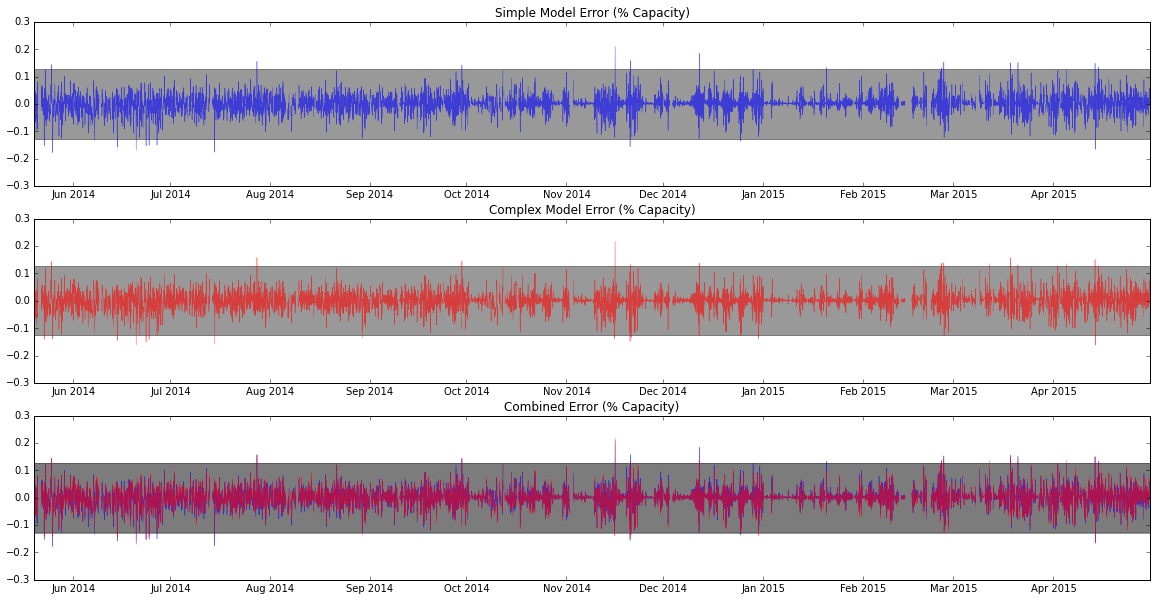

In [53]:
#for ind in anomalies_rfComplex.index:
f, axarr = plt.subplots(3,1)
f.set_figheight(10)
f.set_figwidth(20)
anomalyDegree = 4 # Number of standard deviations covered by gray bands

yScaleMin = -0.3
yScaleMax = 0.3

lo = 0
hi = int(Test_Size)

axarr[0].plot(Result_rfSimple_DataFrame[lo:hi].index, Result_rfSimple_DataFrame.Difference[lo:hi], 
         'b', linewidth = 0.5, alpha = 0.6)
axarr[0].axhspan(anomalyDegree*rfSimple_stDev, -anomalyDegree*rfSimple_stDev, facecolor='k', alpha=0.4)
axarr[0].set_title("Simple Model Error (% Capacity)")
axarr[0].set_ylim([yScaleMin,yScaleMax])

axarr[1].plot(Result_rfComplex_DataFrame[lo:hi].index, Result_rfComplex_DataFrame.Difference[lo:hi], 
         'r', linewidth = 0.5, alpha = 0.6)
axarr[1].axhspan(anomalyDegree*rfComplex_stDev, -anomalyDegree*rfComplex_stDev, facecolor='k', alpha=0.4)
axarr[1].set_title("Complex Model Error (% Capacity)")
axarr[1].set_ylim([yScaleMin,yScaleMax])

axarr[2].plot(Result_rfSimple_DataFrame[lo:hi].index, Result_rfSimple_DataFrame.Difference[lo:hi], 
         'b', linewidth = 0.5, alpha = 0.6)
axarr[2].plot(Result_rfComplex_DataFrame[lo:hi].index, Result_rfComplex_DataFrame.Difference[lo:hi], 
         'r', linewidth = 0.5, alpha = 0.6)
axarr[2].axhspan(anomalyDegree*rfSimple_stDev, -anomalyDegree*rfSimple_stDev, facecolor='k', alpha=0.3)
axarr[2].axhspan(anomalyDegree*rfComplex_stDev, -anomalyDegree*rfComplex_stDev, facecolor='k', alpha=0.3)
axarr[2].set_title("Combined Error (% Capacity)")
axarr[2].set_ylim([yScaleMin,yScaleMax])

plt.show()

**Caption:** This chart shows that the simple and complex model error, i.e. the difference between the predicted output and the actual system output, is not stochastic.  The chart displays all 8,606 predictions for both of the Random Forest models, the simple model in blue and the complex model in red.  The gray shaded ares is the area +/- 4 standard deviations (light gray for complex model, dark gray for simple model) away from the actual system output.  This specific range is shown because were the system stochastic, we would expect to see approximately one prediction outside of the shaded box for each of the models (1 observation in 8,609 should exceed 3.681 sd).  The complex model shows slightly more variability than the simple model (sd_rfComplex = 0.0381, sd_rfSimple = 0.0344) The grey shaded area shows +/- 3.681 standard deviations from the actual value.  It is obvious from this chart that many more outliers exist than would be expected from simple variability for both models.  

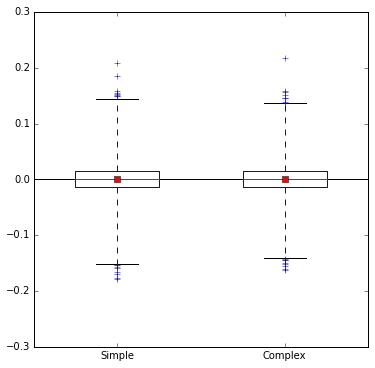

In [54]:
lo = 0
hi = int(Result_rfComplex_DataFrame.dropna().shape[0])

fig, ax1 = plt.subplots(figsize=(6,6))
plt.axhline(color = 'k')
boxPlotData = [Result_rfSimple_DataFrame.Difference[lo:hi].dropna(), 
               Result_rfComplex_DataFrame.Difference[lo:hi].dropna()]

pylab.boxplot(boxPlotData, whis = [0.1,99.9], widths=0.5, showmeans=True)
pylab.xticks([1,2], ["Simple", 'Complex'])
pylab.ylim([-0.3,0.3])

plt.show()

***Caption:*** Boxplot showing the errors of the Simple and complex models.  Whiskers are at 0.1 and 99.9 percentiles.  There is good agreement of the mean (red dots) and the median (red line) in both models.  The Simple model has slightly better fidelity to the actual output, easily seen by the slimmer box and slightly higher 0.1 percentile whisker.

In [55]:
anomalyDegree = 4

anomalies_rfComplex = abs(Result_rfComplex_DataFrame.Difference) > anomalyDegree*rfComplex_stDev
anomalies_rfSimple = abs(Result_rfSimple_DataFrame.Difference) > anomalyDegree*rfSimple_stDev

numAnomaly_rfComplex =sum(anomalies_rfComplex)
numAnomaly_rfSimple =sum(anomalies_rfSimple)
print numAnomaly_rfComplex, numAnomaly_rfSimple

35 29


In [56]:
anomalies_rfComplex = pd.DataFrame([anomalies_rfComplex[anomalies_rfComplex == True]]).transpose()
anomalies_rfSimple = pd.DataFrame([anomalies_rfSimple[anomalies_rfSimple == True]]).transpose()
anomalies_rfComplex.columns = ['Anomaly_T']
anomalies_rfSimple.columns = ['Anomaly_T']

In [57]:
anomalies_rfComplex

,Anomaly_T
2014-05-23 00:00:00,True
2014-05-25 06:00:00,True
2014-05-25 15:00:00,True
2014-06-14 16:00:00,True
2014-06-20 13:00:00,True
...,...
2015-04-14 00:00:00,True
2015-04-14 02:00:00,True
2015-04-15 02:00:00,True
2015-05-02 21:00:00,True


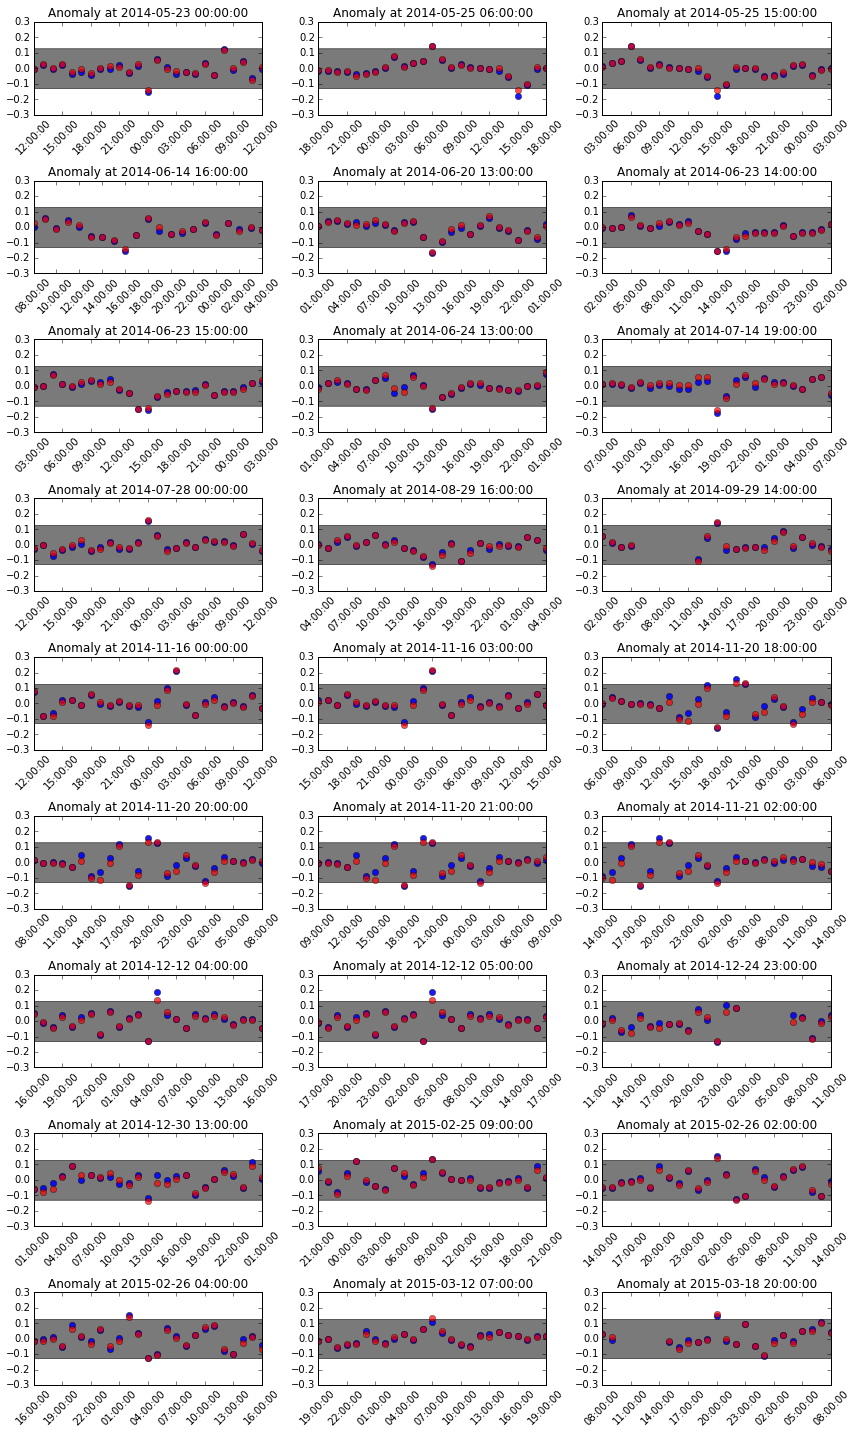

In [58]:
#for ind in anomalies_rfComplex.index:
numplots_y = 9
numplots_x = 3

f, axarr = plt.subplots(numplots_y,numplots_x)
f.set_figheight(20)
f.set_figwidth(12)

anomalyDegree = 4

index = 0

for i in range(0,numplots_y):
    for j in range(0,numplots_x):
        ind = anomalies_rfComplex.index[index]
        lo = ind-pd.DateOffset(hours=12)
        hi = ind+pd.DateOffset(hours=12)

        axarr[i,j].plot(Result_rfSimple_DataFrame[lo:hi].index, Result_rfSimple_DataFrame.Difference[lo:hi], 
                 'bo', linewidth = 0.5, alpha = 0.9)
        axarr[i,j].plot(Result_rfComplex_DataFrame[lo:hi].index, Result_rfComplex_DataFrame.Difference[lo:hi], 
                 'ro', linewidth = 0.5, alpha = 0.7)
        
        axarr[i,j].axhspan(anomalyDegree*rfSimple_stDev, -anomalyDegree*rfSimple_stDev, facecolor='k', alpha=0.4)
        axarr[i,j].axhspan(anomalyDegree*rfComplex_stDev, -anomalyDegree*rfComplex_stDev, facecolor='k', alpha=0.2)
        
        axarr[i,j].set_title("Anomaly at " + str(anomalies_rfComplex.index[index]))
        axarr[i,j].set_ylim([-0.3,0.3])

        index += 1
        
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
f.tight_layout()

In [59]:
#MSW of Simple Model
MSE_rfSimple = mean_squared_error(100*Result_rfSimple_DataFrame.Predict.dropna(), 100*Result_rfSimple_DataFrame.Actual.dropna())

In [60]:
#MSA of Complex Model
MSE_rfComplex = mean_squared_error(100*Result_rfComplex_DataFrame.Predict.dropna(), 100*Result_rfComplex_DataFrame.Actual.dropna())

In [61]:
print[MSE_rfSimple, MSE_rfComplex]

[10.222885831651757, 9.9942431438062265]


The model that includes the time of year in the model significantly outperforms the simple model that does not.

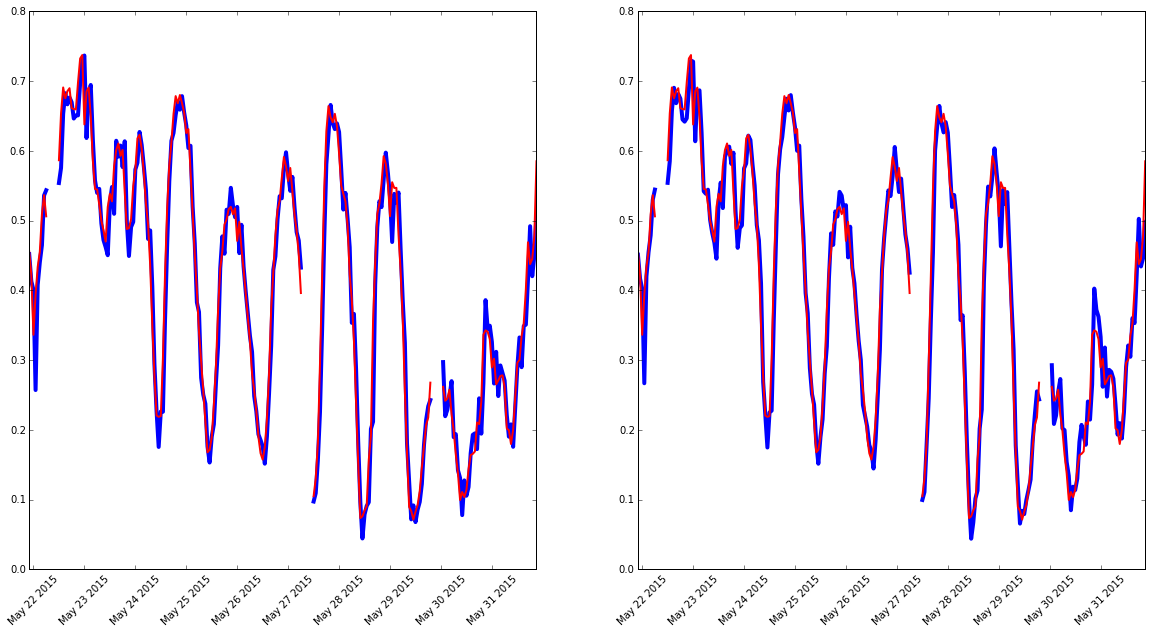

In [62]:
#Final 10 days of modeling
#for ind in anomalies_rfComplex.index:
lo = 0
hi = Result_rfSimple_DataFrame.Predict.shape[0]

f, axarr = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)

yScaleMin = -0.7
yScaleMax = 0.7

axarr[0].plot(Result_rfSimple_DataFrame.index[hi-240:hi], 
              Result_rfSimple_DataFrame.Predict[hi-240:hi], 'b', linewidth = 4)
axarr[0].plot(Result_rfSimple_DataFrame.index[hi-240:hi], 
              Result_rfSimple_DataFrame.Actual[hi-240:hi], 'r', linewidth = 2)

axarr[1].plot(Result_rfComplex_DataFrame.index[hi-240:hi], 
              Result_rfComplex_DataFrame.Predict[hi-240:hi], 'b', linewidth = 4)
axarr[1].plot(Result_rfComplex_DataFrame.index[hi-240:hi], 
              Result_rfComplex_DataFrame.Actual[hi-240:hi], 'r', linewidth = 2)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.show()

###4.1 Feature Importance

In [63]:
importance_Simple = pd.DataFrame({'importance': rf_Simple.feature_importances_}, 
                                  index=X_Simple_Test.columns).sort('importance')

importance_Complex = pd.DataFrame({'importance': rf_Complex.feature_importances_}, 
                                  index=X_Complex_Test.columns).sort('importance')

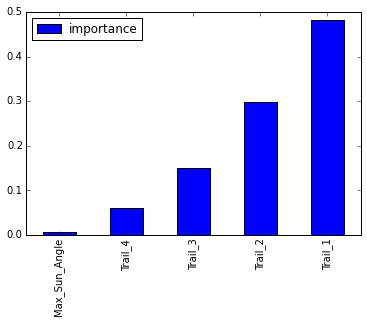

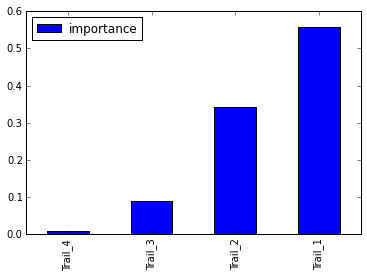

In [64]:
importance_Complex.plot(kind = 'bar')
importance_Simple.plot(kind = 'bar')

plt.show()

***Caption:*** Feature importance of the complex and the simple models.  The simple model puts relatively more importance on the first hour (not difference in scale).  Both models have hourly data in the correct order, meaning that data from four hours ago is less important than that from three hours ago, etc.

##5.0 Conclusions

In [65]:
print MSE_rfSimple, np.sqrt(MSE_rfSimple)

10.2228858317 3.19732479296


In [66]:
print MSE_rfComplex, np.sqrt(MSE_rfComplex)

9.99424314381 3.16136729024


The complex model, which includes data about the time of the year outperforms the simple model slightly, but only slightly.  This makes sense intuitively because the data have strong annual cycle.  I will continue to improve this model, and also include analysis by SVM.